In [1]:
import os
import tensorflow as tf
import numpy as np
import keras
import os
# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
# tf.device('/gpu:1')
os.environ['CUDA_VISIBLE_DEVICES']='0, 1'

import random
import statistics as stat
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,Dropout

In [2]:
import cv2
from imutils import paths

In [3]:
from scipy.constants import lb
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
dataset_path = './dateset'
normal_images = list(paths.list_images(f"{dataset_path}/NORMAL"))
covid_images = list(paths.list_images(f"{dataset_path}/COVID"))
pneumonia_images = list(paths.list_images(f"{dataset_path}/Pneumonia"))

In [6]:
# initialize the initial learning rate, number of epochs to train and batch size
INIT_LR = 1e-3         # [0.00001]
EPOCHS = 50            # [200]
BS = 48                 # [16, 32]
NODES_DENSE0 = 64      # [128]
DROPOUT = 0.5          # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
MAXPOOL_SIZE = (4, 4)  # [(2,2) , (3,3)]
ROTATION_DEG = 15      # [10]
SPLIT = 0.2            # [0.1]

In [7]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...", end = '')
imagePaths = list(paths.list_images(dataset_path))
print("[Done]")
print(dataset_path)
print(len(imagePaths))


[INFO] loading images...[Done]
./dateset
3886


In [8]:
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split('\\')[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    if label == 'Pneumonia':
        labels.append(0)
    if label == 'NORMAL':
        labels.append(1)
    if label == 'COVID':
        labels.append(2)

In [9]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
# 归一化的图片更有利于训练
data = np.array(data) / 255.0
labels = np.array(labels)


In [10]:
# perform one-hot encoding on the labels
# 二值化标签
# import keras
# from keras.utils.np_utils import to_categorical
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
labels = to_categorical(labels,3)

In [11]:
# partition the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=SPLIT,
                                                  stratify=labels,
                                                  random_state=42)

In [12]:
# Data augmentation against Overfiffing
# initialize the training data augmentation object
# 数据扩充
trainAug = ImageDataGenerator(rotation_range=ROTATION_DEG, fill_mode="nearest")
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=MAXPOOL_SIZE)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(NODES_DENSE0, activation="relu")(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=8),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=30)

[INFO] training head...
Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.3824

In [19]:
# H = model.fit(
#     trainAug.flow(trainX, trainY, batch_size=2),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=30)

Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/dense/MatMul_1 (defined at <ipython-input-14-92db81a17327>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2009]

Function call stack:
train_function


In [16]:
def plot_accuraccy(history):
    plt.style.use('seaborn-paper')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

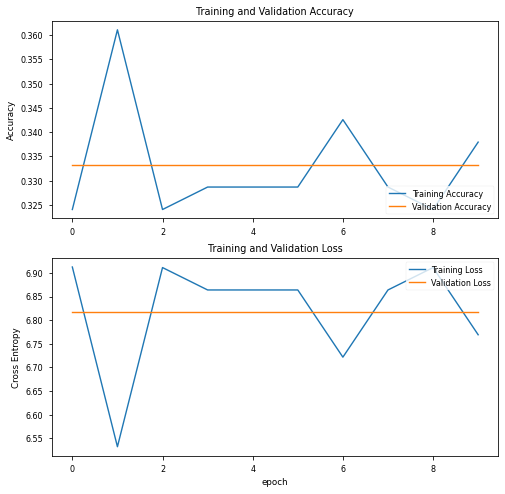

In [17]:
plot_accuraccy(H)